In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# **Preparation of the data**

In [2]:
def get_data_paths(data_dir):
    
    file_paths = []
    label_names = []

    directory = os.listdir(data_dir)
    
    for subdirect in directory:
        if subdirect == 'Master Folder':
            continue
            
        dirpath = os.path.join(data_dir, subdirect)
        filelist = os.listdir(dirpath)
        for file in filelist:
            fpath = os.path.join(dirpath, file)
            file_paths.append(fpath)
            label_names.append(subdirect)
            
    return file_paths, label_names


def create_df(file_paths, label_names):
    df = pd.concat([pd.Series(file_paths, name= 'Paths'), pd.Series(label_names, name='Labels')], axis= 1)
    return df

In [3]:
data_dir = '/kaggle/input/pets-facial-expression-dataset'
file_paths, label_names = get_data_paths(data_dir)
df = create_df(file_paths, label_names)
df

,Paths,Labels
0,/kaggle/input/pets-facial-expression-dataset/O...,Other
1,/kaggle/input/pets-facial-expression-dataset/O...,Other
2,/kaggle/input/pets-facial-expression-dataset/O...,Other
3,/kaggle/input/pets-facial-expression-dataset/O...,Other
4,/kaggle/input/pets-facial-expression-dataset/O...,Other
...,...,...
995,/kaggle/input/pets-facial-expression-dataset/h...,happy
996,/kaggle/input/pets-facial-expression-dataset/h...,happy
997,/kaggle/input/pets-facial-expression-dataset/h...,happy
998,/kaggle/input/pets-facial-expression-dataset/h...,happy


In [4]:
print('Labels number:', df['Labels'].nunique())
class_names = df['Labels'].unique()
print(class_names)

Labels number: 4
['Other' 'Angry' 'Sad' 'happy']


In [5]:
count_images_per_category = df.groupby(['Labels']).count()
count_images_per_category

,Paths
Labels,
Angry,250
Other,250
Sad,250
happy,250


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(179, 179, 3)
(179, 179, 3)
(179, 179, 3)
(179, 179, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(179, 179, 3)
(179, 179, 3)
(224, 224, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(179, 179, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(179, 179, 3)
(179, 179, 3)
(179, 179, 3)


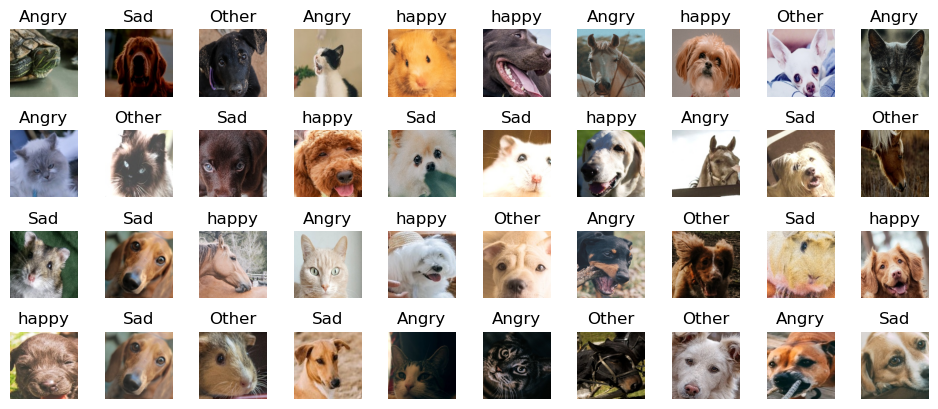

In [6]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        index_img = random.randint(1,1000)
        plt.subplot(n_rows, n_cols, index + 1)
        img_path = df['Paths'][index_img]
        img = plt. imread(img_path)
        print(img.shape)
        plt.imshow(img)
        plt.axis('off')
        plt.title(df['Labels'][index_img], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

# **Preparation of train and test dataset**

In [99]:
# train dataframe
train_df, test_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 42)

In [8]:
batch_size = 16
img_shape = (224, 224, 3)

train = ImageDataGenerator(featurewise_std_normalization=True,
                           rotation_range=30,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.2,0.4],
                           zoom_range=0.2,
                           horizontal_flip=True,
                           vertical_flip=True)

test = ImageDataGenerator(featurewise_std_normalization=True,
                           rotation_range=30,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           brightness_range=[0.2,0.4],
                           zoom_range=0.2,
                           horizontal_flip=True,
                           vertical_flip=True)

train_gen = train.flow_from_dataframe(train_df, 
                                       x_col= 'Paths', 
                                       y_col= 'Labels', 
                                       target_size= img_shape[:2], 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

test_gen = test.flow_from_dataframe(test_df, 
                                      x_col= 'Paths', 
                                      y_col= 'Labels', 
                                      target_size= img_shape[:2], 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= batch_size)

/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


Found 800 validated image filenames belonging to 4 classes.
Found 200 validated image filenames belonging to 4 classes.


# **Model training**


In [9]:
initial_learning_rate = 0.01
epochs = 100

base_model = tf.keras.applications.resnet50.ResNet50(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
base_model.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.5),
    Dense(len(class_names), activation= 'softmax')
])

model.compile(Adamax(learning_rate= initial_learning_rate), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 51

In [10]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               patience=8, 
                               restore_best_weights=True,
                               mode='max',
                              )

def cosine_decay(step):
    step = min(step, epochs)
    cosine_decay = 0.5 * (1 + np.cos(np.pi * step / epochs))
    return initial_learning_rate * cosine_decay

lr_scheduler = LearningRateScheduler(cosine_decay)

In [11]:
epochs = 100

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= test_gen, 
                    validation_steps= None,
                    shuffle= False,
                    callbacks=[early_stopping, lr_scheduler])

/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/100
50/50 [==============================] - 34s 442ms/step - loss: 2.9590 - accuracy: 0.3600 - val_loss: 1.9957 - val_accuracy: 0.3450 - lr: 0.0100
Epoch 2/100
50/50 [==============================] - 15s 306ms/step - loss: 1.3097 - accuracy: 0.3775 - val_loss: 1.2010 - val_accuracy: 0.4100 - lr: 0.0100
Epoch 3/100
50/50 [==============================] - 16s 317ms/step - loss: 1.2019 - accuracy: 0.4675 - val_loss: 1.0976 - val_accuracy: 0.5150 - lr: 0.0100
Epoch 4/100
50/50 [==============================] - 15s 304ms/step - loss: 1.1317 - accuracy: 0.5213 - val_loss: 0.9950 - val_accuracy: 0.6200 - lr: 0.0100
Epoch 5/100
50/50 [==============================] - 16s 324ms/step - loss: 1.1058 - accuracy: 0.5000 - val_loss: 0.9695 - val_accuracy: 0.6250 - lr: 0.0100
Epoch 6/100
50/50 [==============================] - 15s 299ms/step - loss: 0.9982 - accuracy: 0.5638 - val_loss: 0.9302 - val_accuracy: 0.5900 - lr: 0.0099
Epoch 7/100
50/50 [==============================] - 15s 2

# **Model evaluation**

In [12]:
test_score = model.evaluate(test_gen, verbose= 1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

13/13 [==============================] - 3s 225ms/step - loss: 0.4779 - accuracy: 0.8450
Test Loss:  0.47786271572113037
Test Accuracy:  0.8450000286102295


In [13]:
pred = model.predict_generator(test_gen)
y_pred = np.argmax(pred, axis=1)

/tmp/ipykernel_28/1726678021.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_gen)


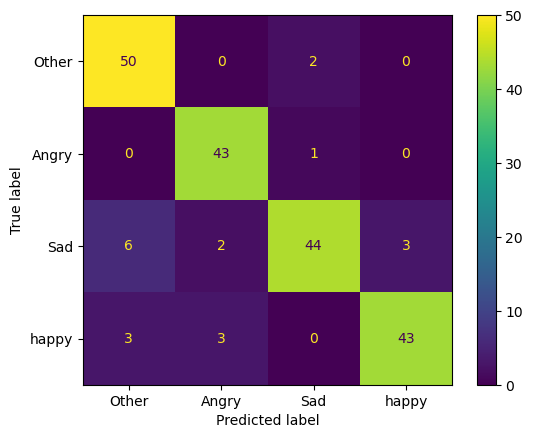

In [14]:
cnf_matrix = confusion_matrix(test_gen.classes, y_pred)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=class_names)
disp.plot()

In [15]:
print(classification_report(test_gen.classes, y_pred, target_names= class_names))

              precision    recall  f1-score   support

       Other       0.85      0.96      0.90        52
       Angry       0.90      0.98      0.93        44
         Sad       0.94      0.80      0.86        55
       happy       0.93      0.88      0.91        49

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



In [16]:
def plot_learning_curves(history, model_name):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    index_loss = np.argmin(history.history['val_loss'])
    val_lowest = history.history['val_loss'][index_loss]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    
    plt.title(f'{model_name} Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_accuracy_curves(history, model_name):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
    index_acc = np.argmax(history.history['val_accuracy'])
    acc_highest = history.history['val_accuracy'][index_acc]
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    
    plt.title(f'{model_name} Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

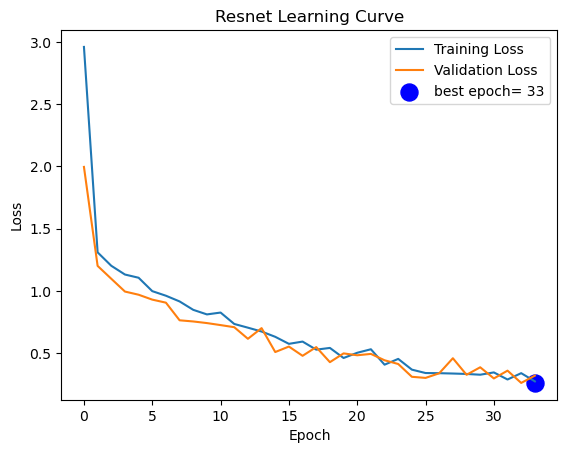

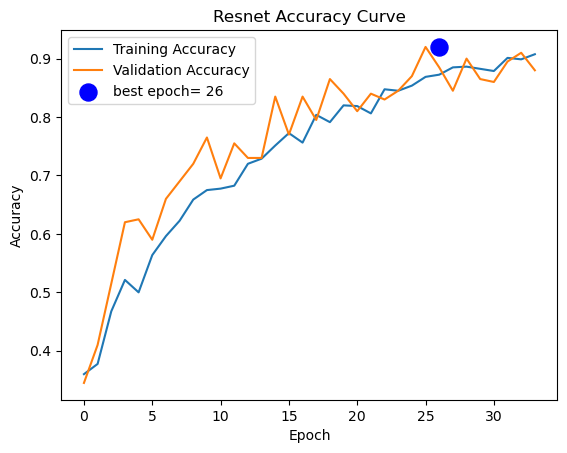

In [17]:
plot_learning_curves(history, 'Resnet')
plot_accuracy_curves(history, 'Resnet')

# **Use of the model**

In [18]:
# model.save_weights('my_model_weights.h5')

In [100]:
test_df = test_df.reset_index()

,index,Paths,Labels
0,521,/kaggle/input/pets-facial-expression-dataset/S...,Sad
1,737,/kaggle/input/pets-facial-expression-dataset/S...,Sad
2,740,/kaggle/input/pets-facial-expression-dataset/S...,Sad
3,660,/kaggle/input/pets-facial-expression-dataset/S...,Sad
4,411,/kaggle/input/pets-facial-expression-dataset/A...,Angry
...,...,...,...
195,408,/kaggle/input/pets-facial-expression-dataset/A...,Angry
196,332,/kaggle/input/pets-facial-expression-dataset/A...,Angry
197,208,/kaggle/input/pets-facial-expression-dataset/O...,Other
198,613,/kaggle/input/pets-facial-expression-dataset/S...,Sad


In [101]:
%matplotlib inline

def show_img(image_nr):
    print('Image nr', image_nr)
    img_path = test_df['Paths'][image_nr]
    real_label = test_df['Labels'][image_nr]
    labels = {0: "Other", 1:"Angry", 2: "Sad", 3: "Happy"}
    print('\nReal label:', real_label)
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    y_pred = model.predict(img_array)
    p = y_pred.max()
    pozycja = np.argmax(y_pred, axis=None)
    print('Predict label: {}\nProbability: {:.2%}, '.format(labels[pozycja], p))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
widgets.interact(show_img, image_nr=widgets.IntSlider(continuous_update=True, min=1, 
                                                      max=200, step=1,
                                                      description='Choose image number:',
                                                      orientation='horizontal'))

interactive(children=(IntSlider(value=1, description='Choose image number:', max=200, min=1), Output()), _dom_…

<function __main__.show_img(image_nr)>